In [2]:
# Paso 0. Importar librerias

# Datos ----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graficos -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer, 
    OneHotEncoder, 
    StandardScaler)
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             f1_score,
                             recall_score,
                             confusion_matrix,
                             classification_report)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import plotly.express as px
import requests
from io import StringIO

# Modelo ---------------------------------------------------------------
from joblib import dump

### 1. Cargar datos
Objetivo: Obtener los datos de la fuente y una primera visión de las propiedades, más una presentación.

In [3]:
df_raw = pd.read_csv("../data/raw/bank-additional-full.csv", sep=';')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

## Dictionary:

|# | Feature | Type        | Description   |
|--|---------|-------------|---------------|
|1 | age     | numeric      | age of person |
|2 | job     | categorical  | type of job:  <br>'admin.'<br>'blue-collar'<br>'entrepreneur'<br>'housemaid'<br>'management'<br>'retired'<br>'self-employed'<br>'services'<br>'student'<br>'technician'<br>'unemployed'<br>'unknown'|
|3 | marital | categorical |marital status: <br>'divorced'<br>'married'<br>'single'<br>'unknown'<br> note: 'divorced' means divorced or widowed|
|4 | education | categorical | status education: <br>'basic.4y'<br>'basic.6y'<br>'basic.9y'<br>'high.school'<br>'illiterate'<br>'professional.course'<br>'university.degree'<br>'unknown'|
|5 | default | categorical | has credit in default? <br>'no'<br>'yes'<br>'unknown'|
|6 | housing | categorical | has housing loan?: <br>'no'<br>'yes'<br>'unknown'|
|7 | loan | categorical | has personal loan?: <br>'no'<br>'yes'<br>'unknown'|

### Related with the last contact of the current campaign:
|# | Feature | Type        | Description   |
|--|---------|-------------|---------------|
|8 | contact | categorical | contact communication type: <br>'cellular'<br>'telephone'|
|9 | month | categorical | last contact month of year: <br>'jan'<br>'feb'<br>'mar'<br> ...<br> 'nov'<br>'dec'|
|10| day_of_week | categorical | last contact day of the week: <br>'mon'<br>'tue'<br>'wed'<br>'thu'<br>'fri'|
|11| duration | numeric | last contact duration, in seconds. <br>Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.|

### Other attributes:

|# | Feature | Type        | Description   |
|--|---------|-------------|---------------|
|12| campaign | numeric | number of contacts performed during this campaign and for this client (numeric, includes last contact)|
|13| pdays | numeric | number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)|
|14| previous | numeric | number of contacts performed before this campaign and for this client|
|15| poutcome | categorical | outcome of the previous marketing campaign: <br>'failure'<br>'nonexistent'<br>'success'|

### Social and economic context attributes

|# | Feature | Type        | Description   |
|--|---------|-------------|---------------|
|16| emp.var.rate | numeric | employment variation rate - quarterly indicator |
|17| cons.price.idx | numeric | consumer price index - monthly indicator |
|18| cons.conf.idx | numeric | consumer confidence index - monthly indicator |
|19| euribor3m | numeric | euribor 3 month rate - daily indicator |
|20| nr.employed | numeric | number of employees - quarterly indicator | 

### Output variable (desired target):
|# | Feature | Type        | Description   |
|--|---------|-------------|---------------|
|21| y | binary | has the client subscribed a term deposit?: <br>'yes'<br>'no'|

In [4]:
df_raw.sample(10, random_state=2025)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
4479,58,retired,married,basic.4y,unknown,no,no,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,yes
24230,51,entrepreneur,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
8307,43,admin.,married,high.school,no,yes,no,telephone,jun,tue,...,2,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,no
4824,31,admin.,married,high.school,no,no,no,telephone,may,wed,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
12201,41,blue-collar,married,basic.6y,no,no,no,telephone,jul,wed,...,5,999,0,nonexistent,1.4,93.918,-42.7,4.956,5228.1,no
20123,36,housemaid,married,basic.6y,no,no,no,cellular,aug,mon,...,2,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
11995,44,admin.,married,university.degree,unknown,yes,yes,telephone,jun,thu,...,4,999,0,nonexistent,1.4,94.465,-41.8,4.955,5228.1,no
9514,45,admin.,married,university.degree,no,yes,no,telephone,jun,mon,...,5,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,no
20217,48,entrepreneur,married,university.degree,no,yes,no,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
8739,22,services,single,high.school,no,no,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,no


## Consideraciones iniciales

- y: al estar desbalanceado es importante considerar técnicas de balanceo o métricas como ROC AUC, F1-score.
- Eliminar duration del modelado realista (pero usarlo como benchmark para comparación).
- Convertir unknown en nulos (NaN) o como categoría si tiene sentido semántico.
- Codificar variables categóricas con one-hot encoding (o label encoding para árboles).
- Evaluar correlaciones y multicolinealidad especialmente en variables económicas.
- Analizar la distribución de y para preparar modelos robustos ante el desbalance.

🔄 ¿Qué representa duration?
Es la duración de la última llamada telefónica (en segundos) entre el agente del banco y el cliente.

🚫 ¿Por qué NO debe usarse para predecir y en un modelo realista?
Porque se conoce solo después de que la llamada ya ocurrió. Por ejemplo:

- Si el cliente cuelga rápido (duración = 0–5 seg), es muy probable que no se suscriba → y = no
- Si el cliente habla más tiempo (ej: >300 seg), suele haber más chances de que termine aceptando la oferta → y = yes

⚠️ Pero: Si estás entrenando un modelo para predecir antes de llamar si vale la pena contactar a ese cliente, no podés saber la duración de la llamada de antemano, porque aún no ha ocurrido.

✅ ¿Por qué puede usarse como benchmark?
Podés incluirla en un modelo solo con fines comparativos, es decir:

- Entrenar dos modelos:
    - Uno realista (sin duration)
    - Uno con duration (benchmark)
- Evaluar cuánto mejora el modelo incluyendo duration, sabiendo que ese modelo no sirve para producción, pero te ayuda a medir el techo de performance del dataset.

📊 Ejemplo práctico:
Supongamos:

- Modelo A (sin duration) → AUC = 0.78
- Modelo B (con duration) → AUC = 0.92

Eso te dice: “Este problema es en parte fácil de resolver si ya sabés cómo fue la llamada, pero sin esa información, el modelo tiene un techo de performance del 78% de AUC”.

In [5]:
print("Describe numerics")
display(df_raw.describe(include='number').T)
print("Describe categoricals")
display(df_raw.describe(include='object').T)

Describe numerics


,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


Describe categoricals


,count,unique,top,freq
job,41188,12,admin.,10422
marital,41188,4,married,24928
education,41188,8,university.degree,12168
default,41188,3,no,32588
housing,41188,3,yes,21576
loan,41188,3,no,33950
contact,41188,2,cellular,26144
month,41188,10,may,13769
day_of_week,41188,5,thu,8623
poutcome,41188,3,nonexistent,35563


## Obervaciones variables numéricas

| Variable                                                      | Observación                                   | Interpretación                                                                                | Posibles estrategias                                                                                                                                    |
| ------------------------------------------------------------- | --------------------------------------------- | --------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `age`                                                         | Rango 17–98, media 40, p75=47                 | Distribución moderadamente sesgada a la derecha (clientes mayores)                            | 1️⃣ Crear bins (18–25, 26–35, … 65+) para entender patrones por etapa de vida<br>2️⃣ O dejarla continua si el modelo es no lineal (árboles)             |
| `duration`                                                    | media < std, máx=4918                         | Distribución muy dispersa. Casos extremos de duración que probablemente indican éxito         | ⚠️ Excluir del modelado predictivo (no conocido antes del contacto), usar solo para **benchmark**                                                       |
| `campaign`                                                    | máx=56, media=2.5, p75=3                      | Alta varianza y casos extremos (outliers)                                                     | 1️⃣ Winsorizar (cap a máx 10, por ejemplo)<br>2️⃣ Evaluar impacto de campañas insistentes en tasa de éxito                                              |
| `pdays`                                                       | media \~962, p25/p50/p75=999                  | Casi todos los valores son 999 (no contactado antes)                                          | 1️⃣ Reemplazar 999 por NaN y crear variable binaria `prev_contacted`<br>2️⃣ O mantenerlo como `categoría` (999 = no contactado)                         |
| `previous`                                                    | media=0.17, p75=0, máx=7                      | Más del 75% nunca tuvo contacto previo                                                        | Similar a `pdays`: usar como binaria o dejar como está si el modelo puede manejar ceros frecuentes                                                      |
| `emp.var.rate`                                                | std > mean, rango -3.4 a 1.4                  | Económicamente relevante. Negativo indica caída en empleo                                     | 1️⃣ Normalizar<br>2️⃣ Evaluar correlación con `y` para decisiones macro                                                                                 |
| `cons.price.idx`, `cons.conf.idx`, `euribor3m`, `nr.employed` | Variables macroeconómicas con baja dispersión | Menor varianza → menor peso individual, pero pueden tener efecto conjunto (multicolinealidad) | 1️⃣ Estudiar correlación entre estas variables<br>2️⃣ PCA opcional si hay redundancia<br>3️⃣ Estandarizar si se usan modelos sensibles (regresión, SVM) |

## Observaciones variables categóricas

| Variable                          | Observación                                    | Interpretación                                                                | Posibles estrategias                                                                                                                       |
| --------------------------------- | ---------------------------------------------- | ----------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------ |
| `job`                             | 12 categorías, predominio de "admin."          | Segmentación laboral: importante para targeting                               | 1️⃣ Reagrupar en sectores si es necesario ("blue collar", "white collar", "student", "retired")<br>2️⃣ One-hot encoding                    |
| `marital`                         | "married" es 60%                               | Estado civil puede influir en riesgo o preferencia de ahorro                  | No reagrupar, usar tal como está. Posible correlación con edad                                                                             |
| `education`                       | "university.degree" y "high.school" dominan    | Nivel educativo alto puede correlacionarse con propensión al ahorro/inversión | Posible codificación ordinal (illiterate < basic < high school < university) o one-hot                                                     |
| `default`, `housing`, `loan`      | Alta proporción de "no" y varios "unknown"     | Potencial omisión o confidencialidad. "unknown" no es aleatorio               | 1️⃣ Analizar si "unknown" se comporta distinto en función de `y`. Si no → imputar / eliminar<br>2️⃣ Si sí → tratarlo como categoría válida |
| `contact`, `month`, `day_of_week` | "cellular" y "may" dominan, "thu" es más común | Podría haber **sesgo de campaña** (ej: mayoría de contactos en mayo y jueves) | 1️⃣ Revisar impacto de "month" en éxito<br>2️⃣ Evitar que el modelo confunda patrón temporal con causalidad                                |
| `poutcome`                        | "nonexistent" en 86%                           | Muy desbalanceada, pero "success" tiene fuerte peso predictivo                | Mantener como está. One-hot encoding recomendado                                                                                           |



## Estrategia General Recomendada

**EDA por segmentos clave:**
- Suscripción (y) por job, education, month, poutcome
- Distribuciones de age, campaign, duration

**Preprocesamiento**
- One-hot encoding de categóricas (o ordinal si aplica)
- Eliminar duration en modelado realista
- Crear variables binarias nuevas (ej: was_contacted_before, has_previous_success)
- Tratar "unknown" como categoría o imputar si tiene suficiente peso

**Modelado**
- Entrenar sin y con balanceo (class_weight='balanced', SMOTE)
- Comparar modelos con ROC AUC y F1

**Explicabilidad**
- Analizar feature importances
- Relacionar findings con decisiones de marketing: ¿Qué perfiles de clientes y qué contexto económico son más sensibles a las campañas?

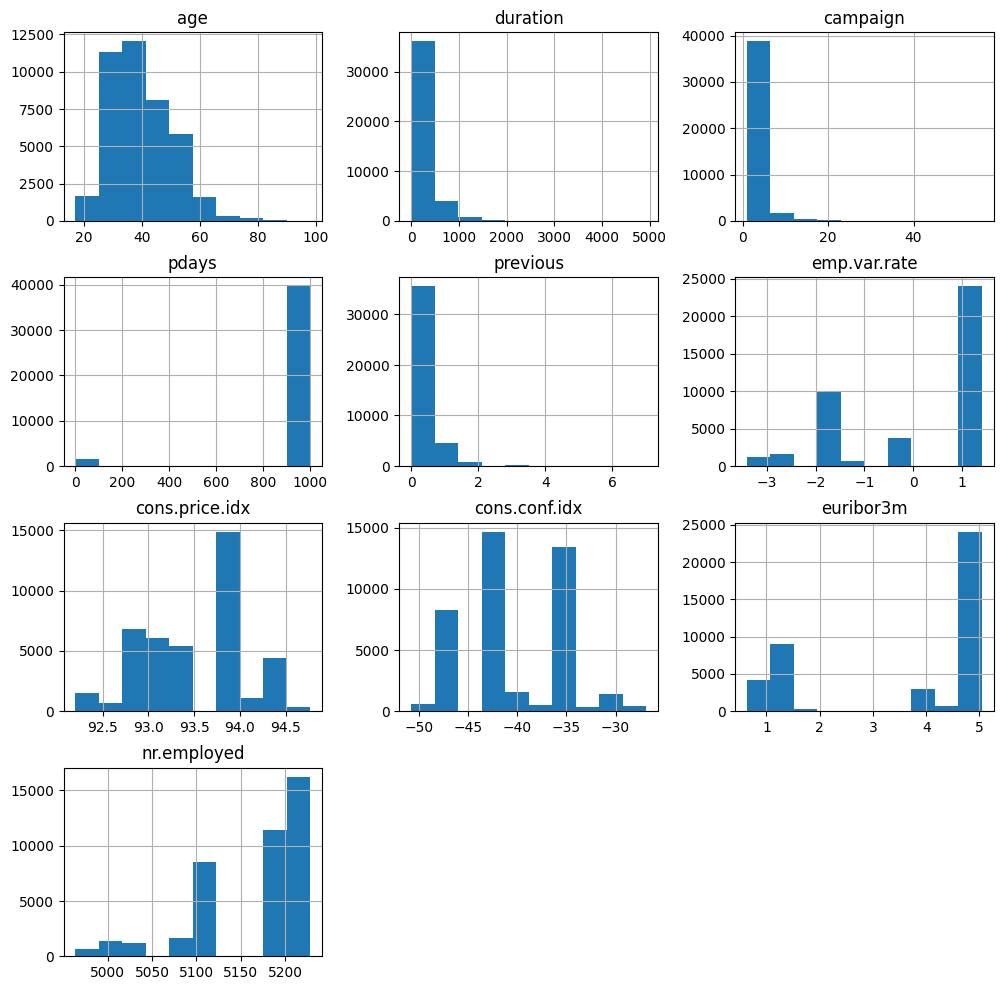

In [6]:
# Análisis univariado (variables numéricas)
df_raw.hist(figsize=(12,12))
plt.show()

## Análisis

| Variable           | Observación visual                                                                          | Conclusiones                                                                                                                                              |
| ------------------ | ------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **age**            | Distribución sesgada a la derecha, concentrada entre 20 y 60 años.                          | ✅ Distribución natural, sin outliers extremos. Se puede dejar continua o aplicar *binning* para análisis por etapa de vida.                               |
| **duration**       | Claramente sesgada. Mayoría de llamadas cortas (muchas en 0–200 seg), con valores extremos. | ⚠️ Confirmación de que debe excluirse del modelo realista. Sirve solo como benchmark. Outliers muy influyentes.                                           |
| **campaign**       | Sesgo fuerte hacia el 1–3. Hay outliers hasta 50+ contactos.                                | 🔎 Hay saturación de llamadas en algunos clientes. Considerar **winsorización** o binarizar >5 contactos.                                                 |
| **pdays**          | Distribución completamente dominada por valor 999.                                          | 🚫 Este valor debe tratarse aparte. Crear variable binaria "fue\_contactado\_previamente". El valor como tal tiene poca utilidad en su forma original.    |
| **previous**       | Mayoría de valores en 0. Muy pocos tienen interacciones previas.                            | ⚠️ Altamente desbalanceada. Puede transformarse en variable binaria: "tuvo\_contactos\_previos".                                                          |
| **emp.var.rate**   | Picos en -1.8 y 1.1. Distribución multimodal.                                               | 📉 Esta variable refleja momentos económicos concretos. Puede tener valor predictivo si se combina con fecha o campaña. Mantener sin modificar por ahora. |
| **cons.price.idx** | Discreta, con valores agrupados en pocos puntos.                                            | 📈 Parece capturada en momentos específicos. Poca variación → poca capacidad explicativa individual, pero útil combinada. No requiere transformación.     |
| **cons.conf.idx**  | Valores agrupados, picos notorios en -41, -36, -45.                                         | Similar a `cons.price.idx`. Mantener como está. Revisar correlación con suscripción (`y`).                                                                |
| **euribor3m**      | Bimodal: mayoría en valores altos (\~5) y otra en valores bajos (\~1).                      | 📊 Indica condiciones monetarias. Puede ser fuerte predictor indirecto. Mantener tal cual. Modelos no lineales pueden capturar bien esta forma.           |
| **nr.employed**    | Concentración en valores alrededor de 5150–5228.                                            | ↔️ Similar a las macroeconómicas anteriores. Alta correlación esperada con `emp.var.rate`. Revisar colinealidad.                                          |


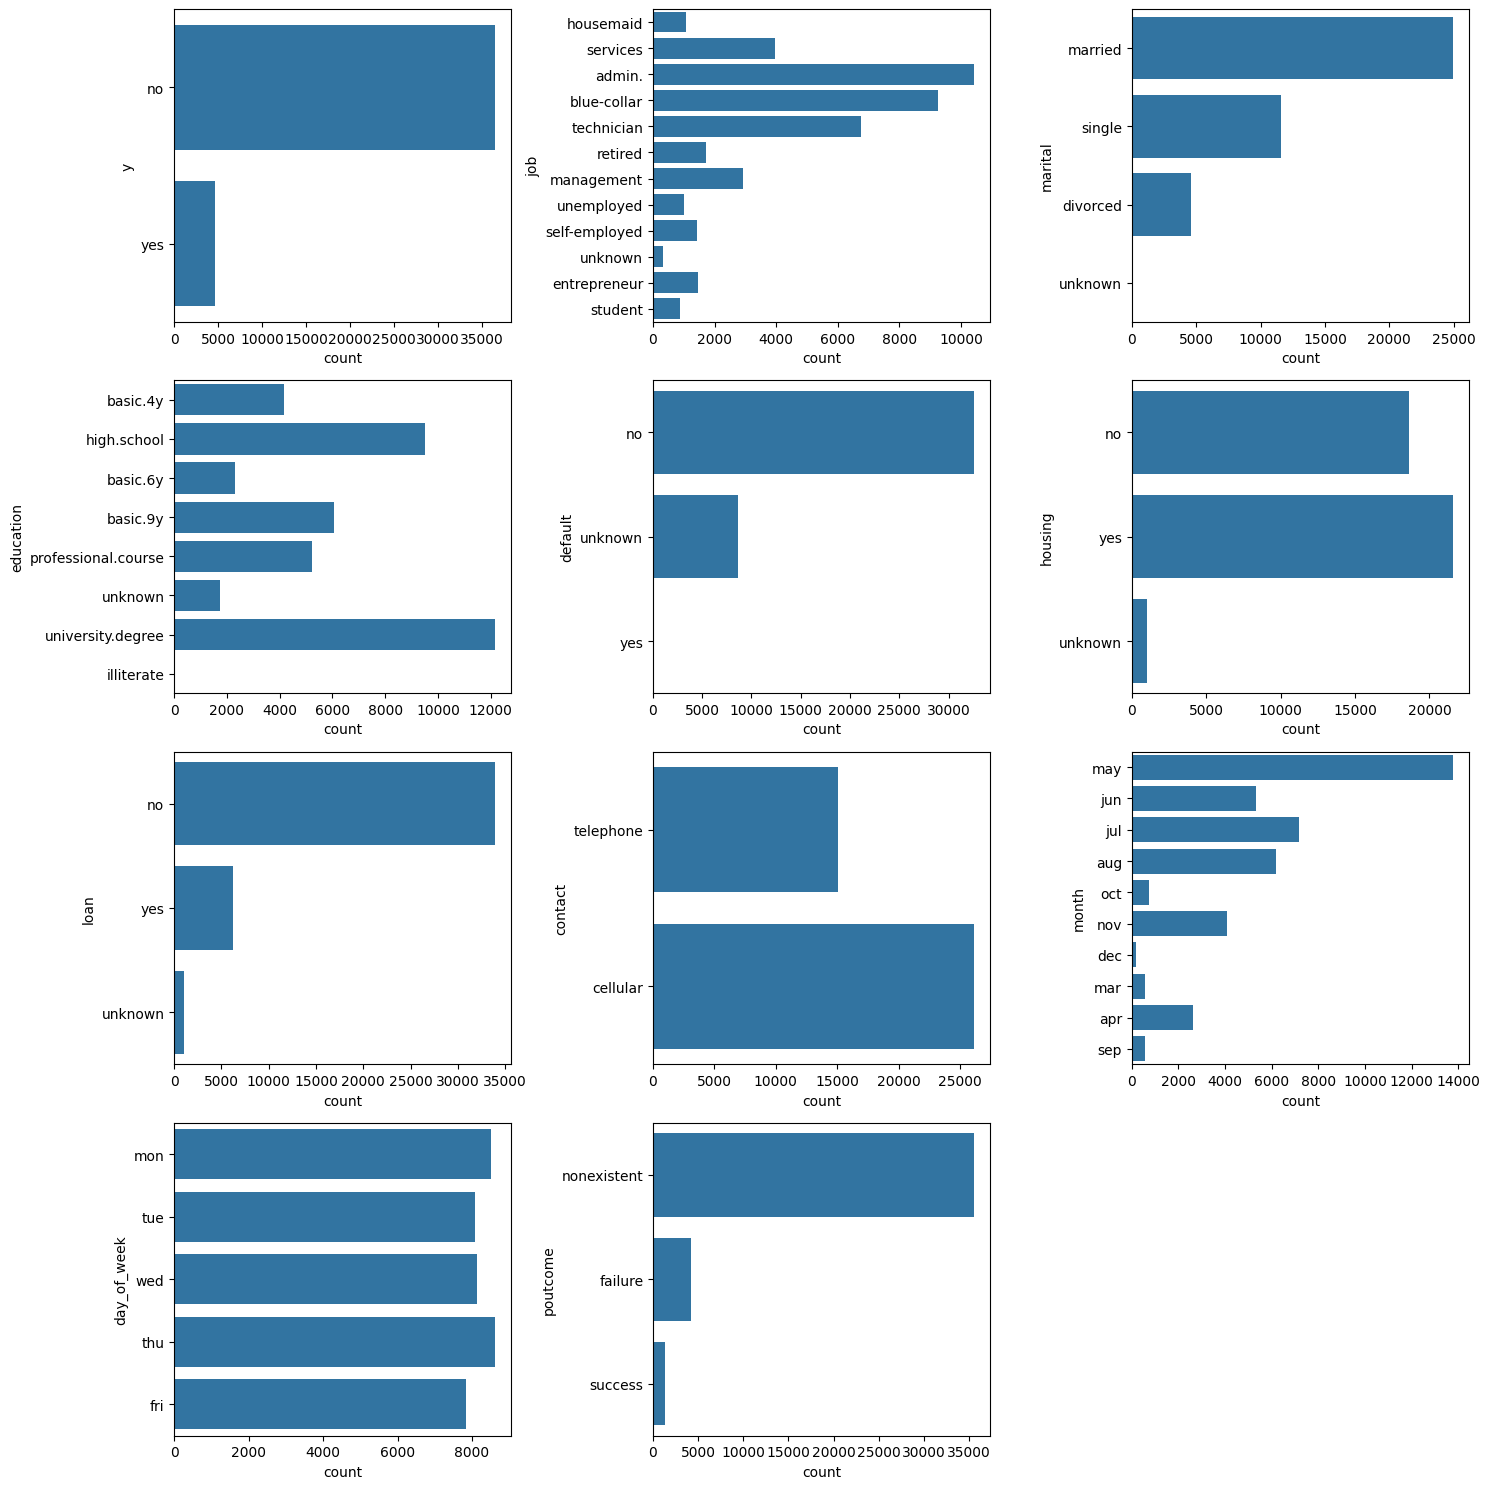

In [7]:
# Analisis univariado (variables categóricas)
fig, ax = plt.subplots(4, 3, figsize=(15, 15))
sns.countplot(data= df_raw, y= 'y', ax= ax[0, 0])
sns.countplot(data= df_raw, y= 'job', ax= ax[0, 1])
sns.countplot(data= df_raw, y= 'marital', ax= ax[0, 2])
sns.countplot(data= df_raw, y= 'education', ax= ax[1, 0])
sns.countplot(data= df_raw, y= 'default', ax= ax[1, 1])
sns.countplot(data= df_raw, y= 'housing', ax= ax[1, 2])
sns.countplot(data= df_raw, y= 'loan', ax= ax[2, 0])
sns.countplot(data= df_raw, y= 'contact', ax= ax[2, 1])
sns.countplot(data= df_raw, y= 'month', ax= ax[2, 2])
sns.countplot(data= df_raw, y= 'day_of_week', ax= ax[3, 0])
sns.countplot(data= df_raw, y= 'poutcome', ax= ax[3, 1])

fig.delaxes(ax[3, 2])
plt.tight_layout()
plt.show()

## Análisis

| Variable          | Observaciones Visuales                                                                                                         | Conclusiones y Estrategias                                                                                                                                                                     |
| ----------------- | ------------------------------------------------------------------------------------------------------------------------------ | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **y (target)**    | Fuerte desbalance: \~88% "no", \~12% "yes"                                                                                     | ⚠️ Confirmado. Evaluar con métricas como **ROC AUC** y **F1-score**. Balanceo con `class_weight`, SMOTE o similar será necesario.                                                              |
| **job**           | Predominan: *admin.*, *blue-collar*, *technician*<br>Categorías con muy pocos ejemplos: *housemaid*, *entrepreneur*, *student* | 1. Podés reagrupar en sectores: "asalariados", "independientes", "sin actividad".<br>2. Algunas clases tienen muy pocos ejemplos → riesgo de sobreajuste con one-hot encoding.               |
| **marital**       | Dominancia clara de "married", seguido por "single"                                                                            | Segmentación clásica. Puede correlacionarse con edad. Mantener. Considerar interacciones con `education` o `job`.                                                                              |
| **education**     | Mayoría tiene "university.degree", luego "high.school". Muchos "unknown"                                                       | 1. Puede codificarse ordinalmente si el modelo lo permite.<br>2. Investigar si los "unknown" se comportan distinto en función de `y`.                                                        |
| **default**       | Mayoría "no", gran cantidad de "unknown", pocos "yes"                                                                          | ⚠️ La clase "yes" es ínfima → puede no aportar valor. <br>➡️ Opción: binarizar (default/no) y agrupar "unknown" como clase separada o eliminar si no aporta valor predictivo.                  |
| **housing**       | Distribución relativamente equilibrada entre "yes" y "no", también hay "unknown"                                               | ✅ Potencialmente informativa. Tratar "unknown" como categoría separada y verificar correlación con `y`.                                                                                        |
| **loan**          | Predomina "no" (\~34k), "yes" y "unknown" con menos peso                                                                       | Similar estrategia a `housing`. Puede ser binaria. Revisar impacto individual y en combinación con `job` o `age`.                                                                              |
| **contact**       | Claramente domina "cellular" sobre "telephone"                                                                                 | ✅ Es informativa. Posible influencia de canal sobre tasa de éxito. Podés cruzarla con `y` para ver diferencias.                                                                                |
| **month**         | Claramente sesgada: pico muy alto en "may", luego caídas fuertes. Pocos casos en "dec", "mar", "apr"                           | ⚠️ Indica **sesgo de campaña**. Puede afectar el modelo si se entrena con datos de campañas más agresivas en ciertos meses. Evaluar `y` por mes. Considerar agrupar meses con baja frecuencia. |
| **day\_of\_week** | Distribución relativamente pareja. "thu" tiene leve pico                                                                       | ✅ No parece tener gran poder predictivo por sí sola. Podría probarse, pero posiblemente tenga poco impacto.                                                                                    |
| **poutcome**      | Dominan "nonexistent", luego "failure", muy pocos "success"                                                                    | ❗ Aunque "success" sea bajo en frecuencia, probablemente tenga **alta correlación positiva con `y`**. One-hot encoding recomendado.                                                            |


In [ ]:
# Analisis bivariado (variables numéricas)
sns.pairplot(df_raw, hue='y')
plt.show()

| Variable Original                 | Transformación Sugerida                                         | Tipo de Acción                     | Justificación                                                            |
| --------------------------------- | --------------------------------------------------------------- | ---------------------------------- | ------------------------------------------------------------------------ |
| `duration`                        | ❌ Eliminar del modelo realista                                  | Eliminación                        | Genera *data leakage*. Solo usar en modelo benchmark.                    |
| `pdays`                           | `was_contacted_before = pdays != 999`                           | Binarización                       | 999 implica "no contactado", muy predominante. Mejora interpretabilidad. |
| `previous`                        | `had_previous_contact = previous > 0`                           | Binarización                       | La mayoría son 0. El valor 1 o más indica historial previo útil.         |
| `campaign`                        | Limitar máximo a 10 o agrupar en 3 categorías                   | Winsorización / Agrupación         | Evita ruido por outliers extremos (>40 contactos).                       |
| `age`                             | Agrupar en rangos etarios (ej: joven/adulto/senior)             | Discretización opcional            | Mejora claridad y posibles relaciones no lineales.                       |
| `emp.var.rate`                    | Mantener o escalar si modelo lo requiere                        | Escalado opcional                  | Influye en contexto económico. Escalar si usás regresión/SVM.            |
| `euribor3m`                       | Mantener o escalar si modelo lo requiere                        | Escalado opcional                  | Potente predictor indirecto. Puede reflejar tasas favorables.            |
| `nr.employed`                     | Mantener o escalar si modelo lo requiere                        | Escalado opcional                  | Altamente correlacionada con empleo y contexto.                          |
| `cons.price.idx`, `cons.conf.idx` | Mantener tal como están o combinar en índice                    | Conservación / Feature engineering | Potencial bajo individual, pero útiles en combinación macroeconómica.    |
| —                                 | `economic_condition_index` (combinación de 3–4 macroeconómicas) | Nueva variable derivada            | Permite capturar contexto global en una sola dimensión.                  |


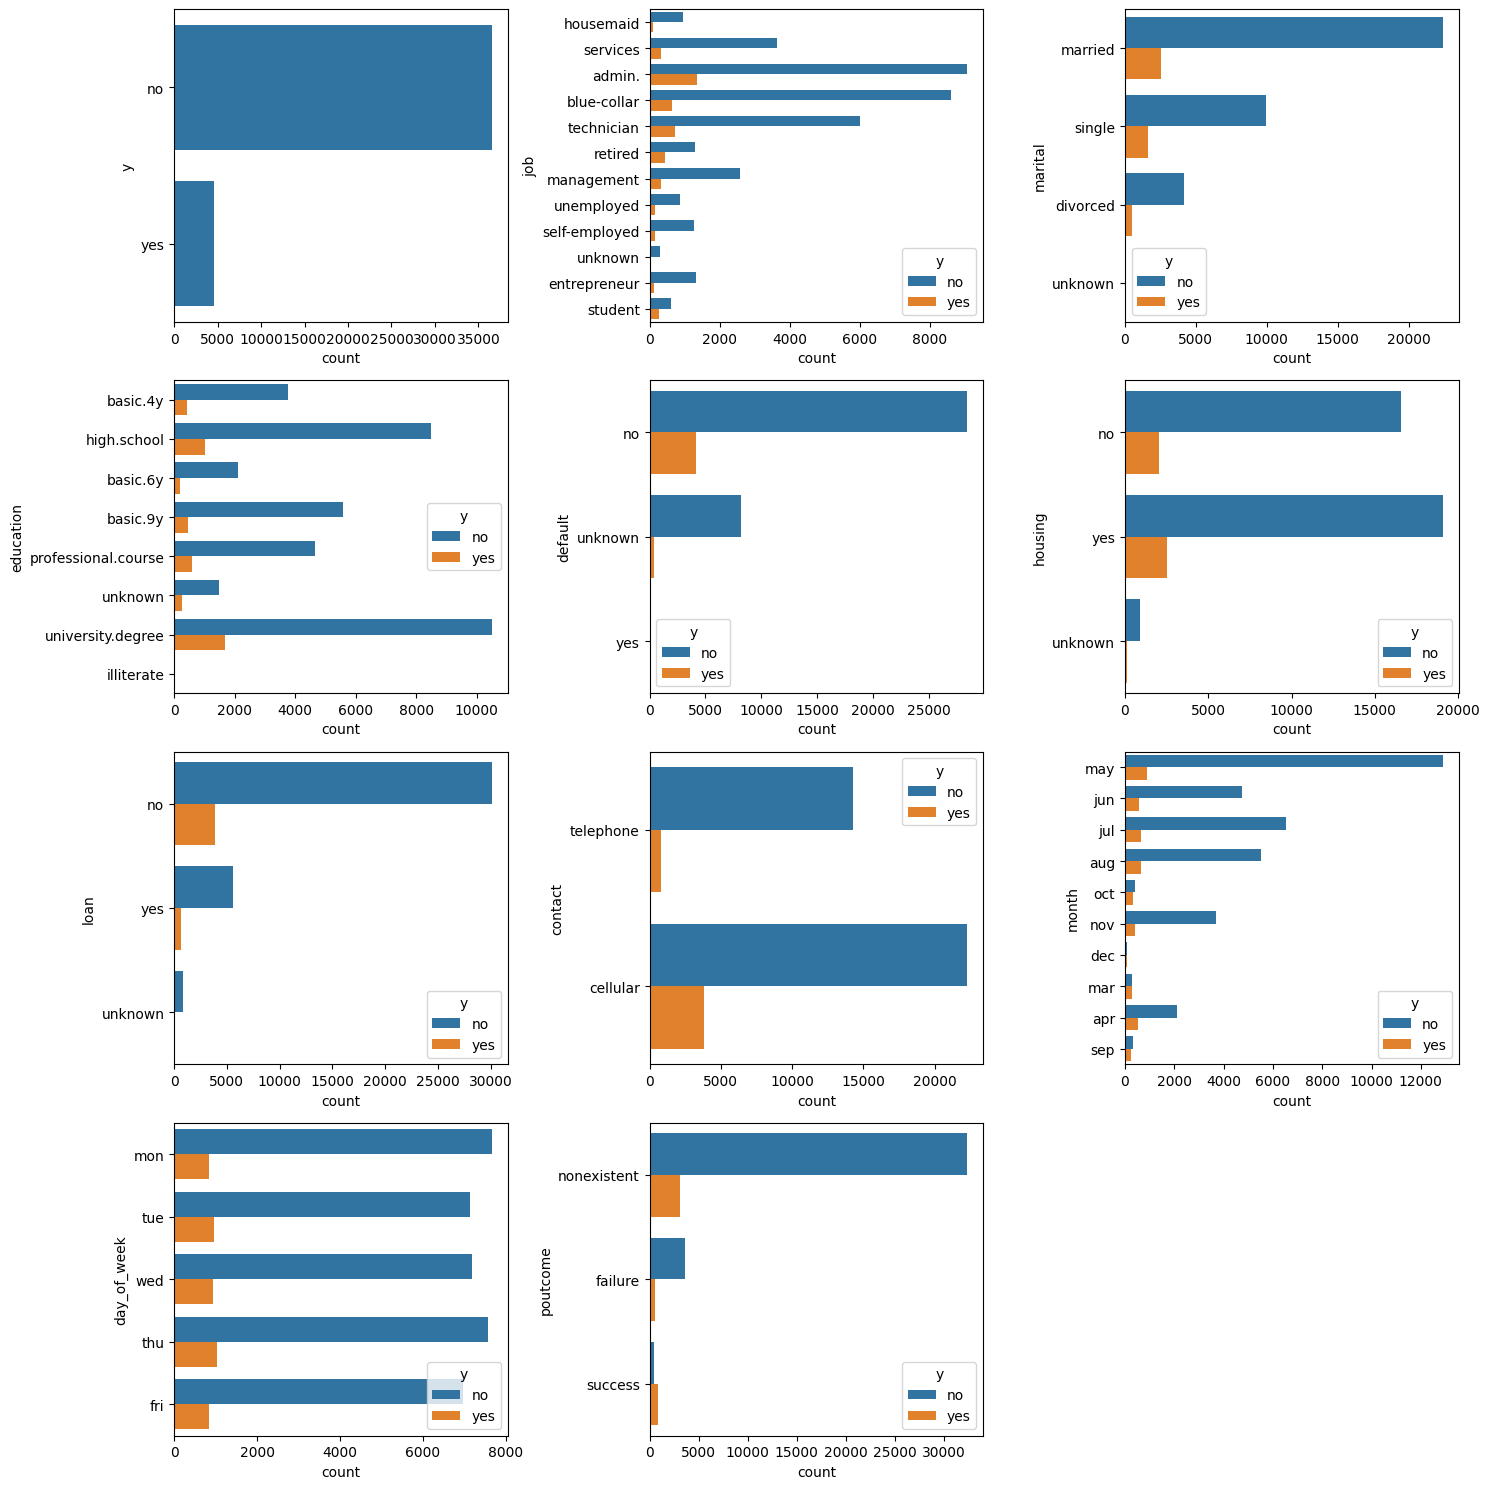

In [ ]:
# Analisis bivariado (variables categóricas)
fig, ax = plt.subplots(4, 3, figsize=(15, 15))
sns.countplot(data= df_raw, y= 'y', ax= ax[0, 0])
sns.countplot(data= df_raw, y= 'job', hue='y', ax= ax[0, 1])
sns.countplot(data= df_raw, y= 'marital', hue='y', ax= ax[0, 2])
sns.countplot(data= df_raw, y= 'education', hue='y', ax= ax[1, 0])
sns.countplot(data= df_raw, y= 'default', hue='y', ax= ax[1, 1])
sns.countplot(data= df_raw, y= 'housing', hue='y', ax= ax[1, 2])
sns.countplot(data= df_raw, y= 'loan', hue='y', ax= ax[2, 0])
sns.countplot(data= df_raw, y= 'contact', hue='y', ax= ax[2, 1])
sns.countplot(data= df_raw, y= 'month', hue='y', ax= ax[2, 2])
sns.countplot(data= df_raw, y= 'day_of_week', hue='y', ax= ax[3, 0])
sns.countplot(data= df_raw, y= 'poutcome', hue='y', ax= ax[3, 1])

fig.delaxes(ax[3, 2])
plt.tight_layout()
plt.show()

| Variable Original | Comportamiento Observado en Bivariado                                          | Estrategia Sugerida                                 | Justificación                                                                |
| ----------------- | ------------------------------------------------------------------------------ | --------------------------------------------------- | ---------------------------------------------------------------------------- |
| `job`             | Algunas profesiones (student, retired, admin.) tienen mayor tasa de conversión | Mantener o reagrupar por sector (white/blue collar) | Mejora interpretabilidad y puede reducir dimensionalidad en modelos lineales |
| `marital`         | Leve mayor proporción de “yes” en single/divorced vs. married                  | Mantener sin cambios                                | Segmentación relevante; podría tener interacción con `age` o `education`     |
| `education`       | Mayor proporción de “yes” en university.degree y professional.course           | Mantener. Considerar codificación ordinal           | Puede tener relación con propensión al ahorro/inversión                      |
| `default`         | Proporción de “yes” baja en todas las clases; muchos unknown                   | Eliminar o reagrupar unknown                        | Poco poder predictivo y valores poco informativos                            |
| `housing`         | Quienes tienen préstamo hipotecario tienden a decir más “no”                   | Mantener. Tratar unknown como categoría             | Puede reflejar carga financiera que afecta decisión                          |
| `loan`            | Quienes no tienen préstamo personal muestran más “yes”                         | Mantener. Tratar unknown como categoría             | Similar lógica que housing. Útil para segmentar perfiles financieros         |
| `contact`         | Cellular tiene notablemente más “yes” que telephone                            | Mantener como está                                  | Indicador claro de canal más efectivo                                        |
| `month`           | Altas tasas de “yes” en meses menos activos (mar, apr, dec, sep)               | Agrupar por trimestre o mantener y codificar        | Riesgo de sesgo de campaña; pero puede tener valor temporal importante       |
| `day_of_week`     | Distribución uniforme, sin patrón evidente                                     | Eliminar (opcional)                                 | Poco poder predictivo aparente                                               |
| `poutcome`        | Alta proporción de “yes” en success; nonexistent domina en cantidad            | Mantener y aplicar one-hot encoding                 | Variable con alta información sobre historial efectivo                       |


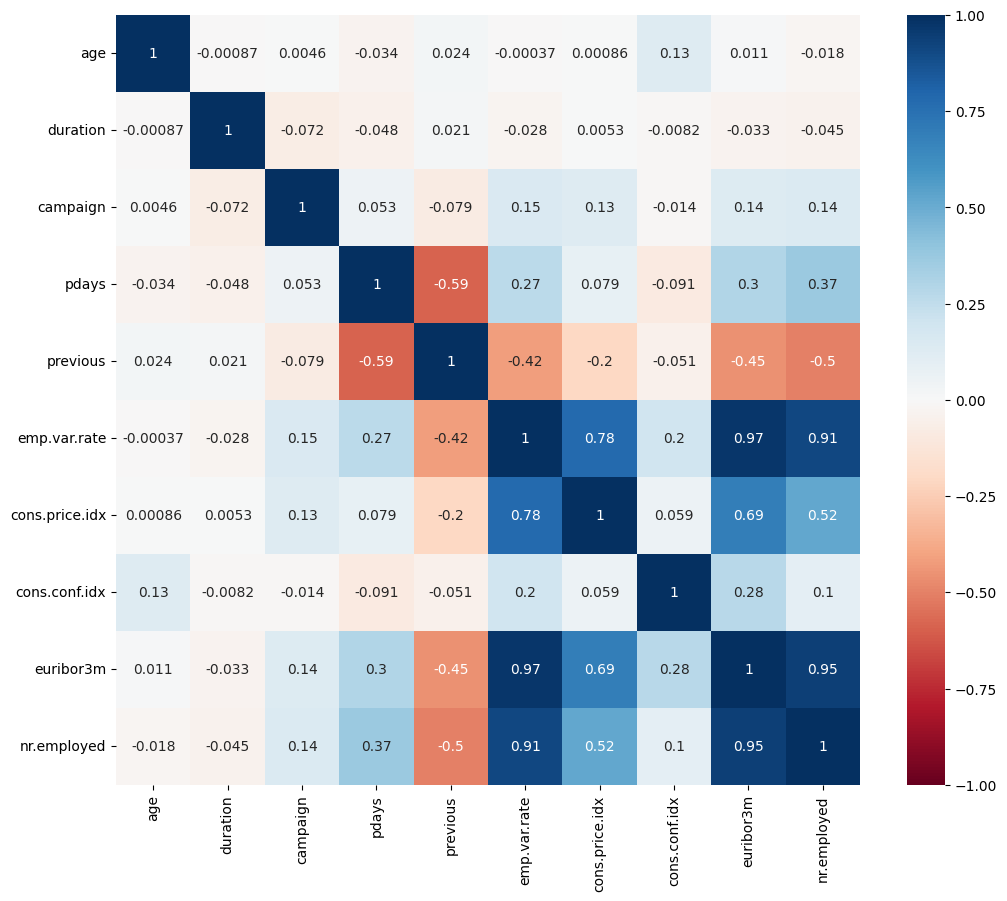

In [ ]:
# Análisis de Correlación
plt.figure(figsize=(12, 10))
sns.heatmap(df_raw.select_dtypes('number').corr(), vmin= -1, vmax= 1, annot= True, cmap='RdBu')
plt.show()

## Análisis

| Variables Involucradas            | Valor de Correlación | Tipo de Acción                               | Justificación                                                                                                                                                   |
| --------------------------------- | -------------------- | -------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `emp.var.rate` & `euribor3m`      | **0.97**             | Reducción de colinealidad (quedarse con una) | Altísima correlación → aportan casi la misma información. Mantener solo una o combinar.                                                                         |
| `emp.var.rate` & `nr.employed`    | **0.91**             | Igual que arriba                             | También están fuertemente ligadas al contexto macroeconómico. Se pueden fusionar en un índice.                                                                  |
| `euribor3m` & `nr.employed`       | **0.95**             | Igual que arriba                             | Si se usa regresión o SVM, esta multicolinealidad puede generar inestabilidad en el modelo.                                                                     |
| `emp.var.rate` & `cons.price.idx` | **0.78**             | Evaluar reducción de dimensionalidad         | Relación moderada-alta. Si se agrupan variables macro en un solo índice, esta puede formar parte.                                                               |
| `pdays` & `previous`              | **-0.59**            | Considerar transformar ambas                 | Relación negativa esperable (más días desde último contacto → menos contactos anteriores). Se pueden usar como `was_contacted_before` y `had_previous_contact`. |
| `previous` & `campaign`           | **-0.08**            | Mantener ambas                               | Correlación muy baja. Aportan información distinta.                                                                                                             |
| Resto de combinaciones            | < ±0.15              | Mantener                                     | Baja colinealidad. Aportan información independiente.                                                                                                           |
